In [1]:
!pip install joblib==1.5.1


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import classification_report, f1_score, confusion_matrix

from joblib import load

zsh:1: command not found: pip


# Understanding the Model

In [32]:
df = pd.read_csv("historical.csv")

df.head()

,baby_id,name,gender,gestational_age_weeks,birth_weight_kg,birth_length_cm,birth_head_circumference_cm,date,age_days,weight_kg,...,oxygen_saturation,feeding_type,feeding_frequency_per_day,urine_output_count,stool_count,jaundice_level_mg_dl,apgar_score,immunizations_done,reflexes_normal,risk_level
0,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-10,1,3.28,...,98,Formula,11,9,0,4.2,7.0,Yes,Yes,At Risk
1,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-11,2,3.35,...,99,Formula,11,5,2,10.6,NaN,No,No,At Risk
2,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-12,3,3.35,...,97,Breastfeeding,7,6,5,9.8,NaN,No,No,Healthy
3,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-13,4,3.48,...,97,Mixed,11,8,4,8.1,NaN,No,Yes,Healthy
4,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-14,5,3.50,...,96,Breastfeeding,11,7,1,11.6,NaN,No,Yes,At Risk


In [33]:
print(f"Shape of the database: {df.shape}")
print()
print(df.dtypes)

Shape of the database: (2100, 25)

baby_id                         object
name                            object
gender                          object
gestational_age_weeks          float64
birth_weight_kg                float64
birth_length_cm                float64
birth_head_circumference_cm    float64
date                            object
age_days                         int64
weight_kg                      float64
length_cm                      float64
head_circumference_cm          float64
temperature_c                  float64
heart_rate_bpm                   int64
respiratory_rate_bpm             int64
oxygen_saturation                int64
feeding_type                    object
feeding_frequency_per_day        int64
urine_output_count               int64
stool_count                      int64
jaundice_level_mg_dl           float64
apgar_score                    float64
immunizations_done              object
reflexes_normal                 object
risk_level                   

The database contains 2100 rows and 25 columns. Specify column names

then next part is highlighting the duplicate names/id numbers

### Handling Null Values

In [ ]:
df.isna().sum()

baby_id                           0
name                              0
gender                            0
gestational_age_weeks             0
birth_weight_kg                   0
birth_length_cm                   0
birth_head_circumference_cm       0
date                              0
age_days                          0
weight_kg                         0
length_cm                         0
head_circumference_cm             0
temperature_c                     0
heart_rate_bpm                    0
respiratory_rate_bpm              0
oxygen_saturation                 0
feeding_type                      0
feeding_frequency_per_day         0
urine_output_count                0
stool_count                       0
jaundice_level_mg_dl              0
apgar_score                    2030
immunizations_done                0
reflexes_normal                   0
risk_level                        0
dtype: int64

then define what Apgar is and why it's probably null

# Dissecting the Model

In [ ]:
# -----------------------------
# Load pipeline (preprocess + LogisticRegression)
# -----------------------------
pipe = load("model.joblib")

pipe

describe the parameters per step

In [26]:
pipe.named_steps['preprocess'].transformers_


[('num',
  StandardScaler(),
  ['gestational_age_weeks',
   'birth_weight_kg',
   'birth_length_cm',
   'birth_head_circumference_cm',
   'age_days',
   'weight_kg',
   'length_cm',
   'head_circumference_cm',
   'temperature_c',
   'heart_rate_bpm',
   'respiratory_rate_bpm',
   'oxygen_saturation',
   'feeding_frequency_per_day',
   'urine_output_count',
   'stool_count',
   'jaundice_level_mg_dl']),
 ('cat',
  OneHotEncoder(drop='if_binary', handle_unknown='ignore'),
  ['gender', 'feeding_type', 'immunizations_done', 'reflexes_normal'])]

note that the 3 columns are missing from the transformers in the preprocessing step of the old model:
- baby_id
- name
- date
- apgar_score

This would probably suggest that these columns were dropped before loading the data into the model. The columns for Baby ID and name may have been dropped because these columns served as unque identifiers or labels of the data points, not a feature or column the model needs to identify patterns. 

Then, explain date (still unsure now why the dropped it)

On the other hand, the column for apgar score may have been dropped because it contains 2030 missing values. Dropping rows will empty values would reduce the database to 70 data points, which is not enough to train the model. Therefore, Data Monitors may have decided to drop the column instead to preserve majority of the data.

In [57]:
target_col = "risk_level"
dropped_col = ["baby_id", "name", "date", "apgar_score"]
X = df.drop(columns=[target_col])
X = X.drop(columns=dropped_col)
y = df[target_col]

In [58]:
# -----------------------------
# Outer split: hold-out test set
# -----------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0
)

# Inner split: train vs validation from outer training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=0
)
# (Resulting split = 60% train, 20% val, 20% test)

In [59]:
model = pipe.fit(X_train, y_train)

train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
test_acc = model.score(X_test, y_test)

In [60]:
print(f"C={1} | Train={train_acc:.4f} | Val={val_acc:.4f} | Test={test_acc:.4f}")

C=1 | Train=0.9278 | Val=0.9310 | Test=0.9095


In [ ]:
df['apgar_score'] = df['apgar_score'].ffill()

# Remove Later

In [16]:
y_act = hist_df["risk_level"].map({"Healthy": 0, "At Risk": 1})
X_old = hist_df.drop("risk_level", axis = 1)

In [17]:
y_pred = model.predict(X_old)

print(f"F1 Score: {f1_score(y_act, y_pred):.4f}")
print(classification_report(y_act, y_pred))

F1 Score: 0.6775
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1822
           1       0.78      0.60      0.68       278

    accuracy                           0.92      2100
   macro avg       0.86      0.79      0.82      2100
weighted avg       0.92      0.92      0.92      2100



In [21]:
X_new = pd.read_csv('test.csv')
y_pred = model.predict(X_new)

# Trying to recreate the Accuracy in the Model Specifications

In [22]:
model  # prints the whole graph

# Or just names
print(model.named_steps.keys())

# Params on each step
print(model.named_steps['preprocess'].get_params())
print(model.named_steps['clf'].get_params())


dict_keys(['preprocess', 'clf'])
{'force_int_remainder_cols': 'deprecated', 'n_jobs': None, 'remainder': 'drop', 'sparse_threshold': 0.3, 'transformer_weights': None, 'transformers': [('num', StandardScaler(), <sklearn.compose._column_transformer.make_column_selector object at 0x759615ad2990>), ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), <sklearn.compose._column_transformer.make_column_selector object at 0x7596159c2ff0>)], 'verbose': False, 'verbose_feature_names_out': True, 'num': StandardScaler(), 'cat': OneHotEncoder(drop='if_binary', handle_unknown='ignore'), 'num__copy': True, 'num__with_mean': True, 'num__with_std': True, 'cat__categories': 'auto', 'cat__drop': 'if_binary', 'cat__dtype': <class 'numpy.float64'>, 'cat__feature_name_combiner': 'concat', 'cat__handle_unknown': 'ignore', 'cat__max_categories': None, 'cat__min_frequency': None, 'cat__sparse_output': True}
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 

### L2

/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 

C=1e-08    | Train=0.9286 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=1e-05    | Train=0.9286 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.001    | Train=0.9286 | Val=1.0000 | Test=0.8571
C=0.1      | Train=0.9286 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.2      | Train=0.9524 | Val=1.0000 | Test=0.8571
C=0.4      | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.75     | Train=1.0000 | Val=1.0000 | Test=0.8571
C=1        | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=1.5      | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=3        | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=5        | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=10       | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=15       | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=20       | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=100      | Train=1.0000 | Val=1.0000 | Test=0.8571


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=300      | Train=1.0000 | Val=0.9286 | Test=0.8571
C=10000    | Train=1.0000 | Val=0.9286 | Test=0.8571


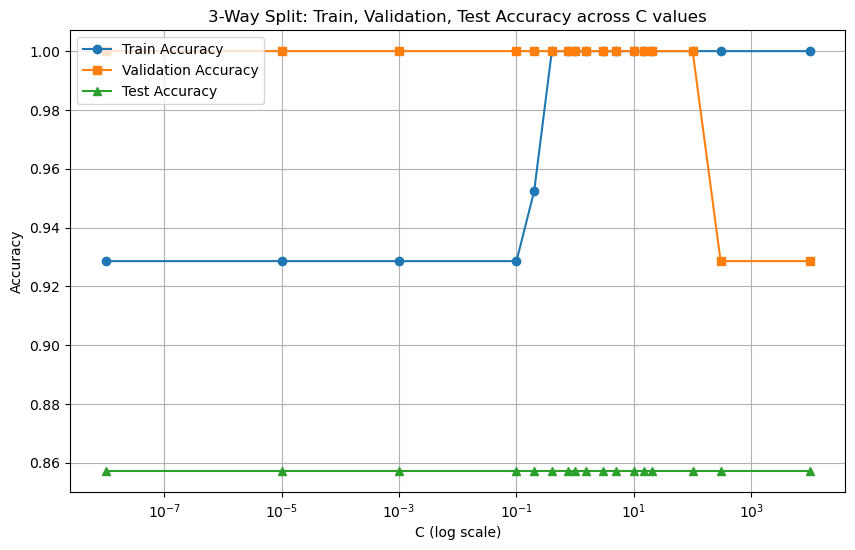

In [ ]:
# -----------------------------
# Load pipeline (preprocess + LogisticRegression)
# -----------------------------
pipe = load("model.joblib")

df = pd.read_csv("historical.csv")
df['apgar_score'] = df['apgar_score'].ffill()

target_col = "risk_level"
X = df.drop(columns=[target_col])
y = df[target_col]

# Patch deprecated param in ColumnTransformer
ct = pipe.named_steps['preprocess']
ct.set_params(force_int_remainder_cols=False)
pipe.named_steps['preprocess'] = ct

# -----------------------------
# Outer split: hold-out test set
# -----------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Inner split: train vs validation from outer training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)
# (Resulting split = 60% train, 20% val, 20% test)

# -----------------------------
# Hyperparameter values
# -----------------------------
C_values = [1e-8, 1e-5, 1e-3, 0.1, 0.2, 0.4, 0.75, 1, 1.5, 3, 5, 10, 15, 20, 100, 300, 10000]

train_accs = []
val_accs = []
test_accs = []

# -----------------------------
# Loop through C values
# -----------------------------
for c_val in C_values:
    # Train on inner train, score on train + val
    model_inner = clone(pipe).set_params(clf__C=c_val, clf__max_iter=2000)
    model_inner.fit(X_train, y_train)

    train_acc = model_inner.score(X_train, y_train)
    val_acc = model_inner.score(X_val, y_val)

    # Retrain on full outer training set, score on test
    model_full = clone(pipe).set_params(clf__C=c_val, clf__max_iter=2000)
    model_full.fit(X_train_full, y_train_full)
    test_acc = model_full.score(X_test, y_test)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    print(f"C={c_val:<8} | Train={train_acc:.4f} | Val={val_acc:.4f} | Test={test_acc:.4f}")

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accs, marker='o', label="Train Accuracy")
plt.plot(C_values, val_accs, marker='s', label="Validation Accuracy")
plt.plot(C_values, test_accs, marker='^', label="Test Accuracy")
plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Accuracy")
plt.title("3-Way Split: Train, Validation, Test Accuracy across C values")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
model_bestC = clone(pipe).set_params(clf__C=1, clf__max_iter=2000)
model_bestC.fit(X_train_full, y_train_full)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x759615f2f860>),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x759615f2f0b0>)])),
                ('clf',
                 LogisticRegression(C=1, max_iter=2000, random_state=0))])

In [28]:
df.iloc[6]

baby_id                              B001
name                                 Sara
gender                             Female
gestational_age_weeks                40.2
birth_weight_kg                       3.3
birth_length_cm                      50.0
birth_head_circumference_cm          31.9
date                           2024-12-16
age_days                                7
weight_kg                            3.53
length_cm                            50.9
head_circumference_cm                32.0
temperature_c                        37.0
heart_rate_bpm                        147
respiratory_rate_bpm                   36
oxygen_saturation                      98
feeding_type                      Formula
feeding_frequency_per_day              11
urine_output_count                      8
stool_count                             1
jaundice_level_mg_dl                  4.0
apgar_score                           7.0
immunizations_done                     No
reflexes_normal                   

In [ ]:
df.iloc[[5]]

,baby_id,name,gender,gestational_age_weeks,birth_weight_kg,birth_length_cm,birth_head_circumference_cm,date,age_days,weight_kg,...,respiratory_rate_bpm,oxygen_saturation,feeding_type,feeding_frequency_per_day,urine_output_count,stool_count,jaundice_level_mg_dl,apgar_score,immunizations_done,reflexes_normal
5,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-15,6,3.46,...,37,97,Mixed,10,6,0,10.1,7.0,No,Yes


In [40]:
df.iloc[[41]]

,baby_id,name,gender,gestational_age_weeks,birth_weight_kg,birth_length_cm,birth_head_circumference_cm,date,age_days,weight_kg,...,oxygen_saturation,feeding_type,feeding_frequency_per_day,urine_output_count,stool_count,jaundice_level_mg_dl,apgar_score,immunizations_done,reflexes_normal,risk_level
41,B002,Nicole,Female,39.4,3.15,50.1,32.0,2025-08-08,12,3.5,...,96,Mixed,8,6,5,3.2,7.0,No,Yes,Healthy


In [34]:
model_bestC.predict(X.iloc[[5]])

array(['At Risk'], dtype=object)

In [39]:
model_bestC.predict(X.iloc[[41]])

array(['Healthy'], dtype=object)

### L1

/opt/conda/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.6.1. This might lead to breaking code o

C=1e-08    | Train=0.8651 | Val=0.8667 | Test=0.8762
C=1e-05    | Train=0.8651 | Val=0.8667 | Test=0.8762
C=0.001    | Train=0.8651 | Val=0.8667 | Test=0.8762


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.1      | Train=0.9183 | Val=0.9357 | Test=0.9214


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.2      | Train=0.9143 | Val=0.9405 | Test=0.9214


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.4      | Train=0.9167 | Val=0.9429 | Test=0.9190


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=0.75     | Train=0.9198 | Val=0.9429 | Test=0.9167


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=1        | Train=0.9222 | Val=0.9405 | Test=0.9119


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=1.5      | Train=0.9270 | Val=0.9357 | Test=0.9095


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=3        | Train=0.9595 | Val=0.9333 | Test=0.9000


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=5        | Train=0.9738 | Val=0.9286 | Test=0.8929


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=10       | Train=0.9770 | Val=0.9190 | Test=0.8881


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=15       | Train=0.9817 | Val=0.9167 | Test=0.8833


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=20       | Train=0.9825 | Val=0.9071 | Test=0.8833


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=100      | Train=0.9841 | Val=0.9071 | Test=0.8857


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=300      | Train=0.9841 | Val=0.8976 | Test=0.8857


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C=10000    | Train=0.9841 | Val=0.8905 | Test=0.8810


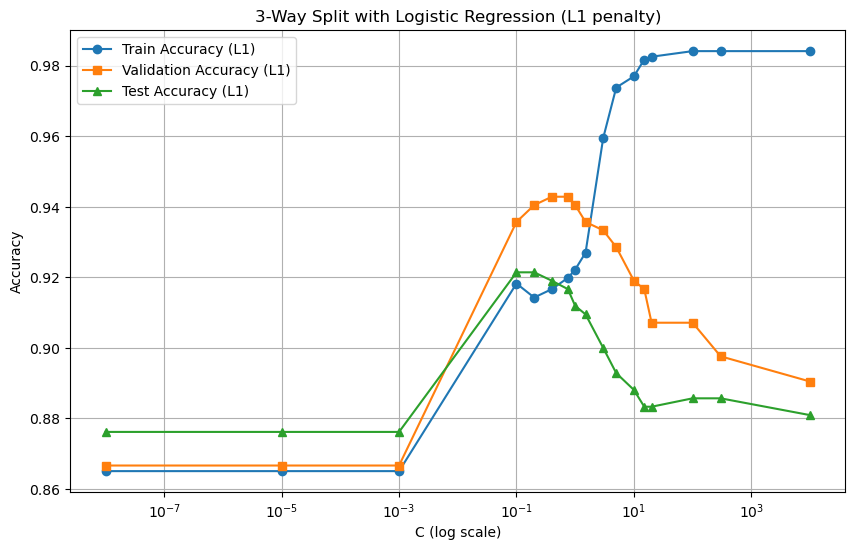

In [43]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from joblib import load
import pandas as pd

# -----------------------------
# Load pipeline (preprocess + LogisticRegression)
# -----------------------------
pipe = load("ML Lab 2/model.joblib")

df = pd.read_csv("ML Lab 2/historical.csv")
df = df.drop(columns=['apgar_score'])

target_col = "risk_level"
X = df.drop(columns=[target_col])
y = df[target_col]

# Patch deprecated param in ColumnTransformer
ct = pipe.named_steps['preprocess']
ct.set_params(force_int_remainder_cols=False)
pipe.named_steps['preprocess'] = ct

# -----------------------------
# Outer split: hold-out test set
# -----------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Inner split: train vs validation from outer training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)
# (Resulting split = 60% train, 20% val, 20% test)

# -----------------------------
# Hyperparameter values
# -----------------------------
C_values = [1e-8, 1e-5, 1e-3, 0.1, 0.2, 0.4, 0.75, 1, 1.5, 3, 5, 10, 15, 20, 100, 300, 10000]

train_accs = []
val_accs = []
test_accs = []

# -----------------------------
# Loop through C values (L1)
# -----------------------------
for c_val in C_values:
    # Train on inner train, score on train + val
    model_inner = clone(pipe).set_params(
        clf__penalty="l1",
        clf__solver="saga",   # saga supports L1 + multiclass
        clf__C=c_val,
        clf__max_iter=5000    # bump iterations for convergence
    )
    model_inner.fit(X_train, y_train)

    train_acc = model_inner.score(X_train, y_train)
    val_acc = model_inner.score(X_val, y_val)

    # Retrain on full outer training set, score on test
    model_full = clone(pipe).set_params(
        clf__penalty="l1",
        clf__solver="saga",
        clf__C=c_val,
        clf__max_iter=5000
    )
    model_full.fit(X_train_full, y_train_full)
    test_acc = model_full.score(X_test, y_test)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    print(f"C={c_val:<8} | Train={train_acc:.4f} | Val={val_acc:.4f} | Test={test_acc:.4f}")

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accs, marker='o', label="Train Accuracy (L1)")
plt.plot(C_values, val_accs, marker='s', label="Validation Accuracy (L1)")
plt.plot(C_values, test_accs, marker='^', label="Test Accuracy (L1)")
plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Accuracy")
plt.title("3-Way Split with Logistic Regression (L1 penalty)")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
nan_counts = df.isna().sum()
nan_counts

baby_id                           0
name                              0
gender                            0
gestational_age_weeks             0
birth_weight_kg                   0
birth_length_cm                   0
birth_head_circumference_cm       0
date                              0
age_days                          0
weight_kg                         0
length_cm                         0
head_circumference_cm             0
temperature_c                     0
heart_rate_bpm                    0
respiratory_rate_bpm              0
oxygen_saturation                 0
feeding_type                      0
feeding_frequency_per_day         0
urine_output_count                0
stool_count                       0
jaundice_level_mg_dl              0
apgar_score                    2030
immunizations_done                0
reflexes_normal                   0
risk_level                        0
dtype: int64

In [37]:
df = df.drop(columns=['baby_id', 'name'])

### L2 without baby id and name

/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 

C=1e-08    | Train=0.8651 | Val=0.8667 | Test=0.8762
C=1e-05    | Train=0.8651 | Val=0.8667 | Test=0.8762
C=0.001    | Train=0.8651 | Val=0.8667 | Test=0.8762
C=0.1      | Train=0.9183 | Val=0.9452 | Test=0.9214
C=0.2      | Train=0.9198 | Val=0.9476 | Test=0.9190
C=0.4      | Train=0.9214 | Val=0.9452 | Test=0.9214
C=0.75     | Train=0.9214 | Val=0.9452 | Test=0.9190
C=1        | Train=0.9206 | Val=0.9452 | Test=0.9190
C=1.5      | Train=0.9206 | Val=0.9452 | Test=0.9214
C=3        | Train=0.9206 | Val=0.9476 | Test=0.9190
C=5        | Train=0.9206 | Val=0.9476 | Test=0.9190
C=10       | Train=0.9206 | Val=0.9452 | Test=0.9190
C=15       | Train=0.9198 | Val=0.9452 | Test=0.9190
C=20       | Train=0.9198 | Val=0.9452 | Test=0.9190
C=100      | Train=0.9183 | Val=0.9429 | Test=0.9167
C=300      | Train=0.9190 | Val=0.9429 | Test=0.9143
C=10000    | Train=0.9190 | Val=0.9429 | Test=0.9143


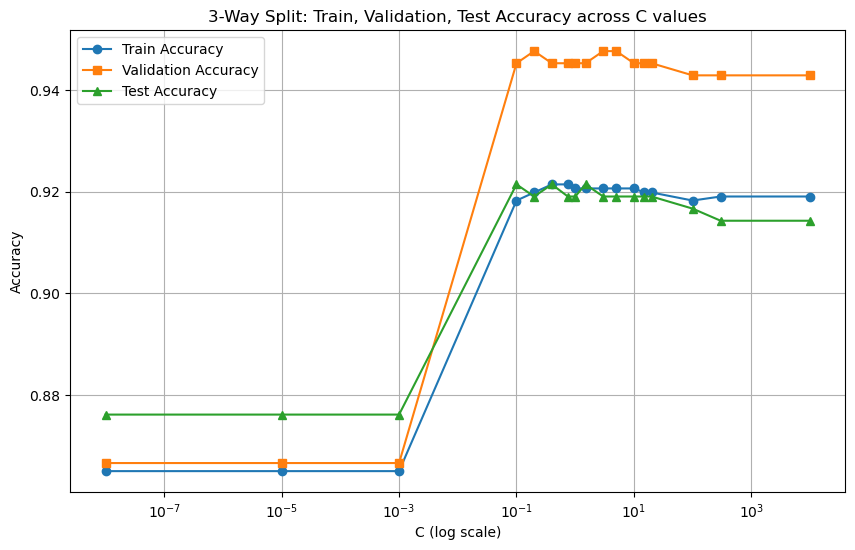

In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from joblib import load
import pandas as pd

# -----------------------------
# Load pipeline (preprocess + LogisticRegression)
# -----------------------------
pipe = load("model.joblib")

df = pd.read_csv("historical.csv")
df['apgar_score'] = df['apgar_score'].ffill()
df = df.drop(columns=['baby_id', 'name', 'date'])

target_col = "risk_level"
X = df.drop(columns=[target_col])
y = df[target_col]

# Patch deprecated param in ColumnTransformer
ct = pipe.named_steps['preprocess']
ct.set_params(force_int_remainder_cols=False)
pipe.named_steps['preprocess'] = ct

# -----------------------------
# Outer split: hold-out test set
# -----------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Inner split: train vs validation from outer training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)
# (Resulting split = 60% train, 20% val, 20% test)

# -----------------------------
# Hyperparameter values
# -----------------------------
C_values = [1e-8, 1e-5, 1e-3, 0.1, 0.2, 0.4, 0.75, 1, 1.5, 3, 5, 10, 15, 20, 100, 300, 10000]

train_accs = []
val_accs = []
test_accs = []

# -----------------------------
# Loop through C values
# -----------------------------
for c_val in C_values:
    # Train on inner train, score on train + val
    model_inner = clone(pipe).set_params(clf__C=c_val, clf__max_iter=2000)
    model_inner.fit(X_train, y_train)

    train_acc = model_inner.score(X_train, y_train)
    val_acc = model_inner.score(X_val, y_val)

    # Retrain on full outer training set, score on test
    model_full = clone(pipe).set_params(clf__C=c_val, clf__max_iter=2000)
    model_full.fit(X_train_full, y_train_full)
    test_acc = model_full.score(X_test, y_test)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    print(f"C={c_val:<8} | Train={train_acc:.4f} | Val={val_acc:.4f} | Test={test_acc:.4f}")

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accs, marker='o', label="Train Accuracy")
plt.plot(C_values, val_accs, marker='s', label="Validation Accuracy")
plt.plot(C_values, test_accs, marker='^', label="Test Accuracy")
plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Accuracy")
plt.title("3-Way Split: Train, Validation, Test Accuracy across C values")
plt.legend()
plt.grid(True)
plt.show()
